# Cancer Detection Final Project
### Zach Bogart
- 12/24/2018

## Prof Notes

- These notes include points on setup of project

**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







## Setup

In [3]:
# Install the OpenSlide C library and Python bindings
# !apt-get install openslide-tools
# !pip install openslide-python 

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from skimage.color import rgb2gray
import h5py

## Drive Import Images

- In the final run, this notebook was run locally to reduce issues with loss of sessions for large datasets. However, this notebook can be run in colab and directly connected to Drive with PyDrive:

In [5]:
# !pip install -U -q PyDrive

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# PyDrive reference:
# https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html

In [6]:
# links to all of the images and their masks
drive_import_dict = [
                  ('1a6MWlEayp48Gk9sJgGRiA_Pwm0ZjTGg9', 'tumor_110.tif'),   #110 for testing
                  ('1th58cTHxw09bi042bFzdzKvgcF0L_tLn', 'tumor_110_mask.tif'),
    
                  ('1d8cK43yey-yMZOtj-d0jWtFCBCZbqPLl', 'tumor_101.tif'),      #101 rest for training
                  ('1NzqLlzfdRDqN-7virUNpXqTh9efMPTba', 'tumor_101_mask.tif'),
                  ('1z2KHy-N7BQfpSoSZ1FS-pqOPR_e3eY6z', 'tumor_096.tif'),      #096
                  ('1j7s-wypTS1xxktaJVcrH0YO1SjCl_9IB', 'tumor_096_mask.tif'),
                  ('1n2pIh-2-wTO0Er5YKye-84YEFsbpq2UH', 'tumor_094.tif'),      #094
                  ('1ngSHKv9aM8irpP69lziNVYaEo5hxkDnP', 'tumor_094_mask.tif'), 
                  ('11RzjCE_ySgk10IPAJEwv4bfgmaBT2dJP', 'tumor_091.tif'),      #091
                  ('1hopHZjnPwR7IHMozgJDBre5rdvR_zx0Y', 'tumor_091_mask.tif'),
                  ('1fnNUMAhZV5zkFP8joNZ3WexaWSywdtgI', 'tumor_084.tif'),      #084
                  ('1OWJQkLp2aMOtAqNQVXWacNN-S3P00bA3', 'tumor_084_mask.tif'),
                  ('1ZerW2rIf_qFH0x21eEq1Ls7V7Y-86n3U', 'tumor_081.tif'),      #081
                  ('12mKJ1nv2Pj8Qcz9fIfZpgorUNwXkr5Tn', 'tumor_081_mask.tif'),
                  ('1cAFgPCkGR0zH0gqCDo4yBnstNoZmjp3C', 'tumor_078.tif'),      #078
                  ('1ZC2urznY3gRebUG3PN2BtYD1ZPZ7GPYq', 'tumor_078_mask.tif'),
                  ('173lssx5bG7u4iQQNtAJRYm4DNRsIupDK', 'tumor_075.tif'),      #075
                  ('16aeh1alpL4Ql5SpNVwWYELakXPzH7Fd3', 'tumor_075_mask.tif'),
                  ('1Mn0nl9w5mMnD6YsJWxaqXy5itNrACcxU', 'tumor_064.tif'),      #064
                  ('1d5-ak53ibjw_1RT6asvdQukf6dYUX_dC', 'tumor_064_mask.tif'),
                  ('19La9AncyGh3wc53sYJKMp-toJceDX7az', 'tumor_059.tif'),      #059
                  ('1RINiVrs7cWXQ9iXjBWcCR2WVbP_8k_QT', 'tumor_059_mask.tif'),
                  ('1nth0QRw25H7EM5ABPY2VUUkOrBk4wDAv', 'tumor_057.tif'),      #057
                  ('1gZBZWUYx5730Xn8xvV8s4SdtCgkXe-qG', 'tumor_057_mask.tif'),
#                   ('_________________________________', '_____________'),      #038
#                   ('_________________________________', '_____________'),
                  ('1p1wIWqJSjB5UVNvc9GJGsGrTGecSbd6_', 'tumor_035.tif'),      #035
                  ('1irttCkQfeTOVkBq87u4bv0sS8q1sG-Mr', 'tumor_035_mask.tif'),
                  ('1Wipj2t56J_ihITdFs7takcOytelovUnM', 'tumor_031.tif'),      #031
                  ('1B6Fe5MZ1FjXFzicKGzM76HXpSO62F4Bc', 'tumor_031_mask.tif'),
                  ('1TirHlOd-onVVWkuB1dJhYJodGu5qmBJK', 'tumor_023.tif'),      #023
                  ('1rAgLyZCejtY0nJQHS8XHqkBOJEgJumZf', 'tumor_023_mask.tif'),
                  ('1kfTtEFehVxety8sZ49-Z-3kN_SB98j7c', 'tumor_019.tif'),      #019
                  ('1FrW1CuDg83UPSjueHrcuXlnTN-nIzBsK', 'tumor_019_mask.tif'),
                  ('1ygfIy44hC7BgQ4xLjCnJA_Sq9xt0XkI2', 'tumor_016.tif'),      #016
                  ('1xx3yLrOWGmcgzwgtDp4SVXpOXF8njwD2', 'tumor_016_mask.tif'),
                  ('1UjdKXUrRD2tQfhJ7eD7kWFSx1zM5xz4r', 'tumor_012.tif'),      #012
                  ('1wE0Bwto5GQcPu7esrAJXnmqkxdJbgMw0', 'tumor_012_mask.tif'),
                  ('1ZkFWpzStEJs4f58nWIvKQkA9D8puBw0n', 'tumor_005.tif'),      #005
                  ('1siowW4hXW8RGXWoZ7_EfiIpeZm9EnvQd', 'tumor_005_mask.tif'),
                  ('1WpNytlQFLKql1GPWhodmixa9Uh4sPbUx', 'tumor_002.tif'),      #002
                  ('1ZpRa1cRLWOAi2UPNnc7Zg02Mf-8Q8dpD', 'tumor_002_mask.tif'),
                  ('18PgD-HCoca5Fp-7l7NdhQ1NEK2P35q0u', 'tumor_001.tif'),      #001
                  ('1bKu35C-S7vfT3HRTalObSZdavAOvzBQg', 'tumor_001_mask.tif')
             ]

In [7]:
# # 3. Load slides by ID and name
# for slide in drive_import_dict:
#     print(slide)
#     downloaded = drive.CreateFile({'id': slide[0]})
#     downloaded.GetContentFile(slide[1])

- At this point, we have all of the slides and their masks loaded:

In [8]:
!ls

model_allData_level06_epochs10_metric_f1_01.h5
past_models
project_zb2223_3_local.ipynb
project_zb2223_4.ipynb
tumor_001.tif
tumor_001_mask.tif
tumor_002.tif
tumor_002_mask.tif
tumor_005.tif
tumor_005_mask.tif
tumor_012.tif
tumor_012_mask.tif
tumor_016.tif
tumor_016_mask.tif
tumor_019.tif
tumor_019_mask.tif
tumor_023.tif
tumor_023_mask.tif
tumor_031.tif
tumor_031_mask.tif
tumor_035.tif
tumor_035_mask.tif
tumor_057.tif
tumor_057_mask.tif
tumor_059.tif
tumor_059_mask.tif
tumor_064.tif
tumor_064_mask.tif
tumor_075.tif
tumor_075_mask.tif
tumor_078.tif
tumor_078_mask.tif
tumor_081.tif
tumor_081_mask.tif
tumor_084.tif
tumor_084_mask.tif
tumor_091.tif
tumor_091_mask.tif
tumor_094.tif
tumor_094_mask.tif
tumor_096.tif
tumor_096_mask.tif
tumor_101.tif
tumor_101_mask.tif
tumor_110.tif
tumor_110_mask.tif
venv


- The slides are now split into arrays. One slide is saved for testing the results, so it is omitted from the training set:

In [9]:
# pick test slide
test_image_filename = 'tumor_110.tif'
test_mask_filename = 'tumor_110_mask.tif'

# get all filenames for slides and masks not in testing
slide_filenames = []
mask_filenames = []

for item in drive_import_dict:
    filename = item[1]
#     print(filename)
    if filename == test_image_filename or filename == test_mask_filename: #for testing...
        continue
    if "_mask" in filename:
        mask_filenames.append(filename)
    else:
        slide_filenames.append(filename)

print(slide_filenames)
print(mask_filenames)

['tumor_101.tif', 'tumor_096.tif', 'tumor_094.tif', 'tumor_091.tif', 'tumor_084.tif', 'tumor_081.tif', 'tumor_078.tif', 'tumor_075.tif', 'tumor_064.tif', 'tumor_059.tif', 'tumor_057.tif', 'tumor_035.tif', 'tumor_031.tif', 'tumor_023.tif', 'tumor_019.tif', 'tumor_016.tif', 'tumor_012.tif', 'tumor_005.tif', 'tumor_002.tif', 'tumor_001.tif']
['tumor_101_mask.tif', 'tumor_096_mask.tif', 'tumor_094_mask.tif', 'tumor_091_mask.tif', 'tumor_084_mask.tif', 'tumor_081_mask.tif', 'tumor_078_mask.tif', 'tumor_075_mask.tif', 'tumor_064_mask.tif', 'tumor_059_mask.tif', 'tumor_057_mask.tif', 'tumor_035_mask.tif', 'tumor_031_mask.tif', 'tumor_023_mask.tif', 'tumor_019_mask.tif', 'tumor_016_mask.tif', 'tumor_012_mask.tif', 'tumor_005_mask.tif', 'tumor_002_mask.tif', 'tumor_001_mask.tif']


- Now we can go through the slides and generate OpenSlide objects for use later:

In [10]:
# open all slides and corrsponding masks and store results
slide_deck = []
mask_deck = []

# slides
for filename in slide_filenames:
    slide_deck.append(open_slide(filename))

# masks
for filename in mask_filenames:
    mask_deck.append(open_slide(filename))

print(slide_deck)
print(mask_deck)

[OpenSlide('tumor_101.tif'), OpenSlide('tumor_096.tif'), OpenSlide('tumor_094.tif'), OpenSlide('tumor_091.tif'), OpenSlide('tumor_084.tif'), OpenSlide('tumor_081.tif'), OpenSlide('tumor_078.tif'), OpenSlide('tumor_075.tif'), OpenSlide('tumor_064.tif'), OpenSlide('tumor_059.tif'), OpenSlide('tumor_057.tif'), OpenSlide('tumor_035.tif'), OpenSlide('tumor_031.tif'), OpenSlide('tumor_023.tif'), OpenSlide('tumor_019.tif'), OpenSlide('tumor_016.tif'), OpenSlide('tumor_012.tif'), OpenSlide('tumor_005.tif'), OpenSlide('tumor_002.tif'), OpenSlide('tumor_001.tif')]
[OpenSlide('tumor_101_mask.tif'), OpenSlide('tumor_096_mask.tif'), OpenSlide('tumor_094_mask.tif'), OpenSlide('tumor_091_mask.tif'), OpenSlide('tumor_084_mask.tif'), OpenSlide('tumor_081_mask.tif'), OpenSlide('tumor_078_mask.tif'), OpenSlide('tumor_075_mask.tif'), OpenSlide('tumor_064_mask.tif'), OpenSlide('tumor_059_mask.tif'), OpenSlide('tumor_057_mask.tif'), OpenSlide('tumor_035_mask.tif'), OpenSlide('tumor_031_mask.tif'), OpenSlide

## Reading Slides Functions

- This is the meat of the project: the functions that read in the data to create subimages for testing.

In [11]:
'''
This function was provided for us in the starter code. It takes in an OpenSlide object
and returns a numpy array that we can use to plot images with.
'''

# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [12]:
'''
In order to reduce the amount of data fed into the final network, we
want to learn on regions that have tissue, rather than just grey images
(of which there are a bunch). So this function calculates the amount
of tissue in the input so some filtering can be done later on.
'''

# find percentage of window that is tissue to avoid training on gray images
def calculate_tissue_percentage(slide_region, window_size, tissue_threshold=0.01):
    
    image_width = window_size
    image_height = window_size

    def find_tissue_pixels(image, intensity=0.8):
        im_gray = rgb2gray(image)
        assert im_gray.shape == (image.shape[0], image.shape[1])
        indices = np.where(im_gray <= intensity)
        return list(zip(indices[0], indices[1]))
    
    tissue_pixels = find_tissue_pixels(slide_region)
    percent_tissue = len(tissue_pixels) / float(image_width * image_height) * 100
    
    return percent_tissue
    

In [13]:
'''
This is the workhorse. This function takes in a slide and returns subimages to train on.
Essentially, it is chopping up the image a bunch and identifying if the little images have
cancer in them or not (defined as pixel of mask present in subimage). Really grey images
with no tissue are ignored. A boolean can be switched off to use this function to generate
the heatmap at the end.
'''

# creates subimages of slide and returns as a list
def add_subimages_to_training_images(slide, mask, level, window_size, stride, remove_grey_slides = True):
    
    tissue_threshold = 0.01
    too_grey = 0
    cancer_count = 0
    
    image_deck = []
    mask_deck = []
    mask_labels = []
    
    image_width = slide.level_dimensions[level][0]
    image_height = slide.level_dimensions[level][1]
    
#     print("({}, {})".format(image_width, image_height))
    
    x_coord = 0
    y_coord = 0
    downsample_factor = int(slide.level_downsamples[level])
#     print(type(downsample_factor))
    
    # loop thru the image
    while y_coord < (image_height - window_size + 1):
        
        while x_coord < (image_width - window_size + 1):
            
            # slide image
            slide_region = read_slide(slide, 
                         x= x_coord * downsample_factor, 
                         y= y_coord * downsample_factor, 
                         level= level, 
                         width= window_size, 
                         height= window_size)
            
            # mask image
            mask_region = read_slide(mask, 
                         x= x_coord * downsample_factor, 
                         y= y_coord * downsample_factor, 
                         level= level, 
                         width= window_size, 
                         height= window_size)

            mask_region = mask_region[25:-25, 25:-25, 0]

            # cancer label
            cancer_present = np.amax(mask_region)
   
            
            if remove_grey_slides:
                # ignore really gray images without any tissue
                percent_tissue = calculate_tissue_percentage(slide_region, window_size)
    
                if percent_tissue > tissue_threshold:
                    if cancer_present:
                        cancer_count += 1
                    image_deck.append(slide_region)
                    mask_deck.append(mask_region)
                    mask_labels.append(cancer_present)
            
                else:
                    too_grey += 1
            
            else:
                if cancer_present:
                    cancer_count += 1
                image_deck.append(slide_region)
                mask_deck.append(mask_region)
                mask_labels.append(cancer_present)
            
            # move by stride
            x_coord += stride
        
        # end of row, reset and move down by stride
        x_coord = 0
        y_coord += stride
        
    
#     print("Too grey images: ", too_grey)
#     print("Cancer Subimages: ", cancer_count)
    
    print("Finished Slide")
    return image_deck, mask_deck, mask_labels

In [14]:
'''
Helpful for debugging, this function displayes the desired image or mask
along with its dimensions, level, and title. 
'''

# opens slide and shows as output at given level
def show_me_this_image(slide_name, level):
    slide_object = open_slide(slide_name)
    width = slide_object.level_dimensions[level][0]
    height = slide_object.level_dimensions[level][1]

    image_result = read_slide(slide_object, 
                                x=0, 
                                y=0, 
                                level=level, 
                                width=width, 
                                height=height)
    
    if "mask" in slide_name:
        image_result = image_result[:,:,0]
    
    print("Image Title: ", slide_name)
    print("Level: ", level)
    print("Dimensions: ({}, {})".format(width, height))
    
    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow(image_result)


In [15]:
'''
Used for heatmap masking, this returns the mask of an image as an array.
'''

# opens slide and shows as output at given level
def get_me_mask_nparray(mask_name, level):
    slide_object = open_slide(mask_name)
    width = slide_object.level_dimensions[level][0]
    height = slide_object.level_dimensions[level][1]

    image_result = read_slide(slide_object, 
                                x=0, 
                                y=0, 
                                level=level, 
                                width=width, 
                                height=height)
    
    if "mask" in mask_name:
        image_result = image_result[:,:,0]
    
    print("Image Title: ", mask_name)
    print("Level: ", level)
    print("Dimensions: ({}, {})".format(width, height))
    
    return image_result

- Here is an example of a slide and its corresponding mask:

Image Title:  tumor_094.tif
Level:  6
Dimensions: (1856, 1568)
Image Title:  tumor_094_mask.tif
Level:  6
Dimensions: (1856, 1568)


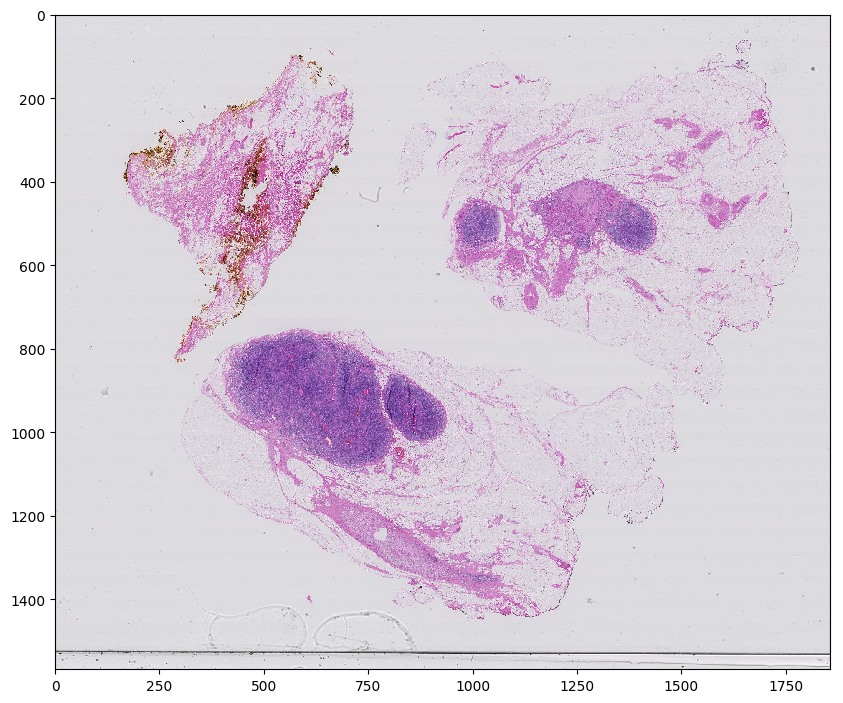

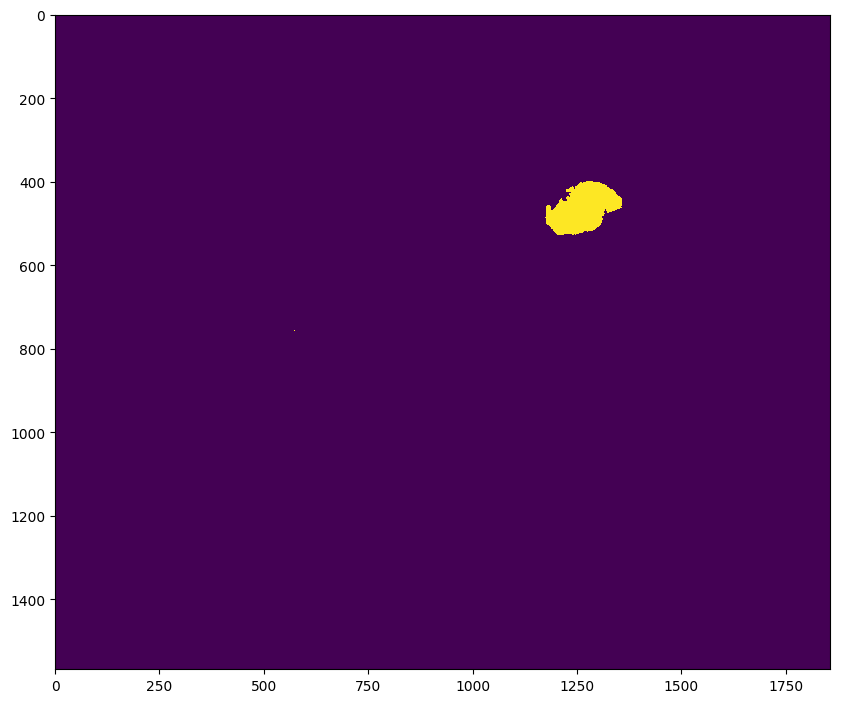

In [16]:
show_me_this_image('tumor_094.tif', level = 6)
show_me_this_image('tumor_094_mask.tif', level = 6)

## Make Subimages and Submasks
- Here we split up the slides into subimages for training. It is also here that we define the size of the subimages (window_size), the steps taken every time for a new image, causing helpful overlap (stride), and the zoom level of the image, lower is bigger (level).

In [17]:
print(slide_deck)
print(mask_deck)

[OpenSlide('tumor_101.tif'), OpenSlide('tumor_096.tif'), OpenSlide('tumor_094.tif'), OpenSlide('tumor_091.tif'), OpenSlide('tumor_084.tif'), OpenSlide('tumor_081.tif'), OpenSlide('tumor_078.tif'), OpenSlide('tumor_075.tif'), OpenSlide('tumor_064.tif'), OpenSlide('tumor_059.tif'), OpenSlide('tumor_057.tif'), OpenSlide('tumor_035.tif'), OpenSlide('tumor_031.tif'), OpenSlide('tumor_023.tif'), OpenSlide('tumor_019.tif'), OpenSlide('tumor_016.tif'), OpenSlide('tumor_012.tif'), OpenSlide('tumor_005.tif'), OpenSlide('tumor_002.tif'), OpenSlide('tumor_001.tif')]
[OpenSlide('tumor_101_mask.tif'), OpenSlide('tumor_096_mask.tif'), OpenSlide('tumor_094_mask.tif'), OpenSlide('tumor_091_mask.tif'), OpenSlide('tumor_084_mask.tif'), OpenSlide('tumor_081_mask.tif'), OpenSlide('tumor_078_mask.tif'), OpenSlide('tumor_075_mask.tif'), OpenSlide('tumor_064_mask.tif'), OpenSlide('tumor_059_mask.tif'), OpenSlide('tumor_057_mask.tif'), OpenSlide('tumor_035_mask.tif'), OpenSlide('tumor_031_mask.tif'), OpenSlide

In [18]:
window_size = 100
stride = 10
level = 6

slide_subimages = []
slide_submasks = []
slide_sublabels = []

for ind in range(len(slide_deck)):
    print(ind)
    subimages, submasks, sublabels = add_subimages_to_training_images(slide_deck[ind], mask_deck[ind], level, window_size, stride)
    slide_subimages.extend(subimages)
    slide_submasks.extend(submasks)
    slide_sublabels.extend(sublabels)

slide_subimages = np.array(slide_subimages)
slide_submasks = np.array(slide_submasks)
slide_sublabels = np.array(slide_sublabels)



0
Finished Slide
1
Finished Slide
2
Finished Slide
3
Finished Slide
4
Finished Slide
5
Finished Slide
6
Finished Slide
7
Finished Slide
8
Finished Slide
9
Finished Slide
10
Finished Slide
11
Finished Slide
12
Finished Slide
13
Finished Slide
14
Finished Slide
15
Finished Slide
16
Finished Slide
17
Finished Slide
18
Finished Slide
19
Finished Slide


In [19]:
# Look at shapes

print("Images: ", slide_subimages.shape)
print("Masks : ", slide_submasks.shape)
print("Labels: ", slide_sublabels.shape)

Images:  (334592, 100, 100, 3)
Masks :  (334592, 50, 50)
Labels:  (334592,)


## Observe Results

- here we take a look at the results of splitting up the slides. We can see that the images are classified as having cancer present or not, which is defined as a inner bounding box (which can be seen in the plots below).

In [20]:
# get some indices where cancer shows up
count = 0
for ind in range(len(slide_sublabels)):
    if slide_sublabels[ind] == 1:
        print(str(ind) + ", ", end = "")
        count += 1
    
    if count >= 100:
        break

1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 

Cancer?:  1


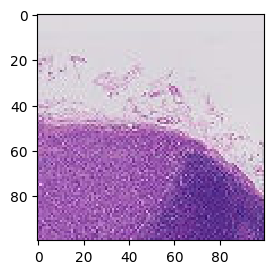

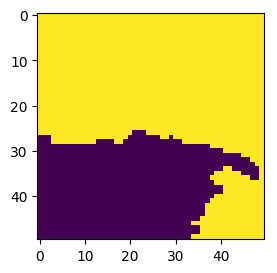

In [21]:
sub_ind = 2558

plt.figure(figsize=(3,3), dpi=100)
plt.imshow(slide_subimages[sub_ind]) 

print("Cancer?: ", slide_sublabels[sub_ind])

plt.figure(figsize=(3,3), dpi=100)
plt.imshow(slide_submasks[sub_ind], cmap='viridis_r') 

## Split data

- Now we split the data into train/val/test for the network

In [22]:
# Look at shapes

print("Images: ", slide_subimages.shape)
print("Masks : ", slide_submasks.shape)
print("Labels: ", slide_sublabels.shape)

Images:  (334592, 100, 100, 3)
Masks :  (334592, 50, 50)
Labels:  (334592,)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(slide_subimages, slide_sublabels, test_size=0.33, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [24]:
print("X_train", X_train.shape)
print("X_val", X_val.shape)
print("X_test", X_test.shape)

print("y_train", y_train.shape)
print("y_val", y_val.shape)
print("y_test", y_test.shape)

X_train (150197, 100, 100, 3)
X_val (73979, 100, 100, 3)
X_test (110416, 100, 100, 3)
y_train (150197,)
y_val (73979,)
y_test (110416,)


## Import ConvNet

- Here we setup the CNN. Early on, I experimented with transfer learning using VGG16 (commented out, can play with results still; unfroze deep layers and trained those), but after discussing with the TA during my presentation, we decided on using a CNN trained from scratch. This was because I was getting poor results, which may have been due to the pre-trained CNN being trained with ImageNet, which is very useful, but not very applicable for this medical-domain-specific project (there are no cats to find in images, for example).

In [25]:
import keras
keras.__version__

# from keras.applications import VGG16

Using TensorFlow backend.


'2.2.4'

In [26]:
# conv_base = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape = (window_size, window_size, 3))



In [27]:
# type(conv_base)

In [28]:
# conv_base.summary()

## Create Model

In [29]:
from keras import models
from keras import layers

# model = models.Sequential()
# model.add(conv_base)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(window_size, window_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
__________

In [31]:
# print('This is the number of trainable weights '
#       'before freezing the conv base:', len(model.trainable_weights))

# conv_base.trainable = False

# print('This is the number of trainable weights '
#       'after freezing the conv base:', len(model.trainable_weights))

In [33]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [34]:
history = model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=128,
          validation_data=(X_val, y_val))

Train on 150197 samples, validate on 73979 samples
Epoch 1/10
150197/150197 [==============================] - 4645s 31ms/step - loss: 0.1671 - acc: 0.9563 - val_loss: 0.2800 - val_acc: 0.8607
Epoch 2/10
150197/150197 [==============================] - 3463s 23ms/step - loss: 0.0970 - acc: 0.9666 - val_loss: 0.0862 - val_acc: 0.9715
Epoch 3/10
150197/150197 [==============================] - 3384s 23ms/step - loss: 0.0871 - acc: 0.9695 - val_loss: 0.0823 - val_acc: 0.9717
Epoch 4/10
150197/150197 [==============================] - 3067s 20ms/step - loss: 0.0801 - acc: 0.9720 - val_loss: 0.0793 - val_acc: 0.9718
Epoch 5/10
150197/150197 [==============================] - 2793s 19ms/step - loss: 0.0750 - acc: 0.9734 - val_loss: 0.0847 - val_acc: 0.9664
Epoch 6/10
150197/150197 [==============================] - 2692s 18ms/step - loss: 0.0702 - acc: 0.9748 - val_loss: 0.0658 - val_acc: 0.9770
Epoch 7/10
150197/150197 [==============================] - 2729s 18ms/step - loss: 0.0672 - acc:

## Save off Model

In [35]:
model.save('model_allData_level06_epochs10_metric_acc_01.h5') 

## Evaluate Model

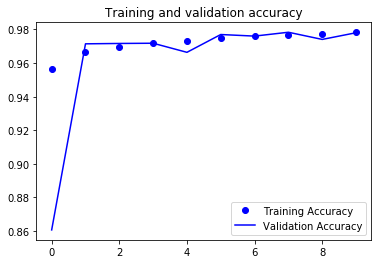

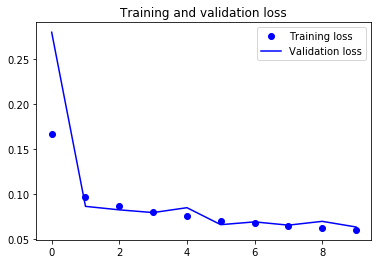

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Load Previous Model

In [37]:
# from keras.models import load_model

# model = load_model('model_01.h5')

## Evaluate on Test

In [38]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test acc score:', test_acc)

110416/110416 [==============================] - 482s 4ms/step
test acc score: 0.9775757136646863


## Test on New Image

- at this point, we want to give the trained CNN a new image and see if it can identify whether cancer is present or not.

In [39]:
test_images = []
test_masks = []

test_images.append(open_slide(test_image_filename))
test_masks.append(open_slide(test_mask_filename))

print(test_images)
print(test_masks)

[OpenSlide('tumor_110.tif')]
[OpenSlide('tumor_110_mask.tif')]


In [40]:
# window_size = 100
# stride = 10
# level = 7

testing_slide_subimages = []
testing_slide_submasks = []
testing_slide_sublabels = []

for ind in range(len(test_images)):
    subimages, submasks, sublabels = add_subimages_to_training_images(test_images[ind], test_masks[ind], level, 
                                                                      window_size, stride, remove_grey_slides = False)
    testing_slide_subimages.extend(subimages)
    testing_slide_submasks.extend(submasks)
    testing_slide_sublabels.extend(sublabels)

testing_slide_subimages = np.array(testing_slide_subimages)
testing_slide_submasks = np.array(testing_slide_submasks)
testing_slide_sublabels = np.array(testing_slide_sublabels)

Finished Slide


In [41]:
# Look at shapes

print("Images: ", testing_slide_subimages.shape)
print("Masks : ", testing_slide_submasks.shape)
print("Labels: ", testing_slide_sublabels.shape)

Images:  (14214, 100, 100, 3)
Masks :  (14214, 50, 50)
Labels:  (14214,)


In [42]:
# make blank slide array
width = test_images[0].level_dimensions[level][0]
height = test_images[0].level_dimensions[level][1]

predicted_mask = np.zeros((height, width))

# stride = 10
# window_size = 100
tissue_threshold = 0.01
cancer_threshold = 0.8

x_coord = 0
y_coord = 0

for item in testing_slide_subimages:
    
    if calculate_tissue_percentage(item, window_size) > tissue_threshold:
        
        item = item.reshape((1, 100, 100, 3))
    #     print(model.predict(item)[0][0])
        cancer_pred = model.predict(item)[0][0] # get prediction value for cancer/no cancer
    #     print(cancer_pred)

        if cancer_pred > cancer_threshold:
            predicted_mask[int(y_coord + (window_size / 2) - (stride / 2)):int(y_coord + (window_size / 2) + (stride / 2)), 
                           int(x_coord + (window_size / 2) - (stride / 2)):int(x_coord + (window_size / 2) + (stride / 2))] = 1
    
    x_coord += stride
    if x_coord > (width - window_size):
        x_coord = 0
        y_coord += stride
    

- Below is the predicted mask of the test slide:

(1120, 1472)


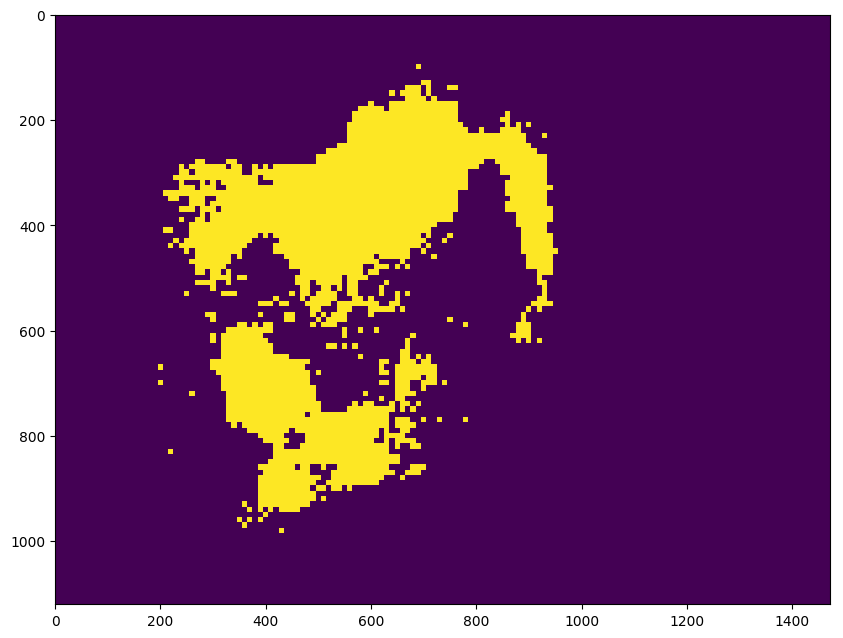

In [43]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(predicted_mask)

print(predicted_mask.shape)

- not bad right? Below is the original image and the ground truth mask:

Image Title:  tumor_110.tif
Level:  6
Dimensions: (1472, 1120)
Image Title:  tumor_110_mask.tif
Level:  6
Dimensions: (1472, 1120)


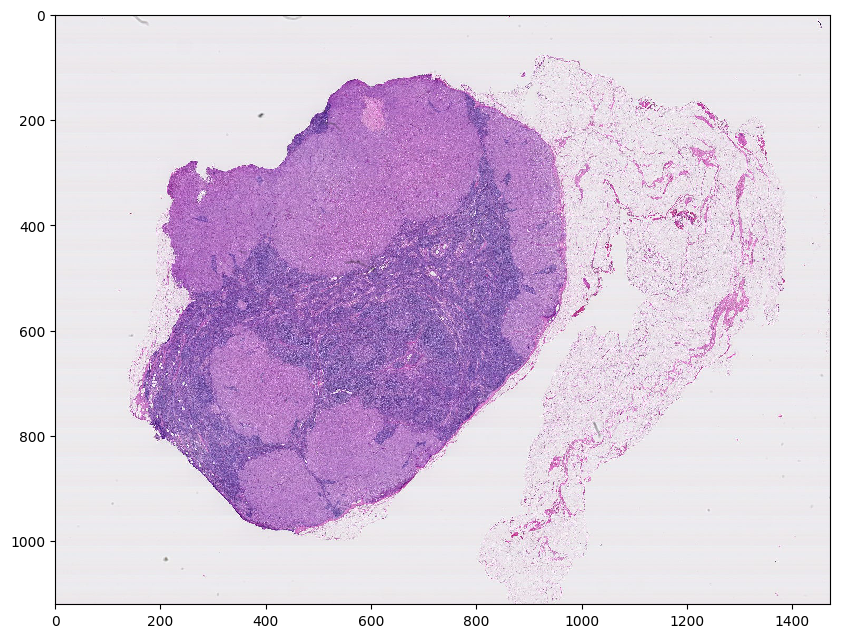

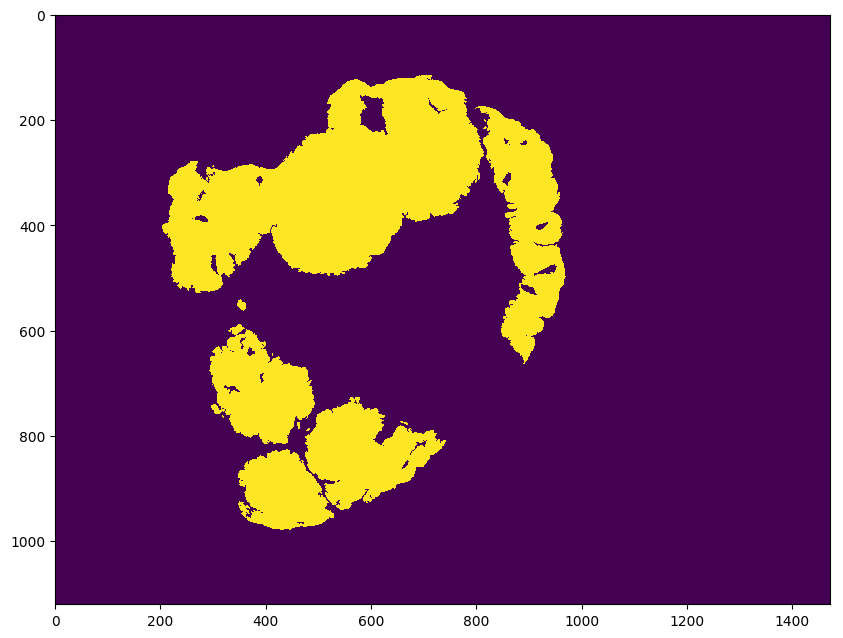

In [44]:
show_me_this_image(test_image_filename, level = level)
show_me_this_image(test_mask_filename, level = level)

## Metrics

In [45]:
ground_truth = get_me_mask_nparray(test_mask_filename, level = level)

ground_truth.shape

Image Title:  tumor_110_mask.tif
Level:  6
Dimensions: (1472, 1120)


(1120, 1472)

In [46]:
accuracy = ground_truth - (2 * predicted_mask)
# 1 is something in ground truth but in prediction (false_negative)
# -1 is both in ground truth and prediction (true_positive)
# -2 is something in prediction but not ground truth (false_positive)
# 0 is in neither (true_negative)

In [48]:
# accuracy = np.absolute(accuracy)
false_positive = len(accuracy[accuracy == -2])
true_positive = len(accuracy[accuracy == -1])
false_negative = len(accuracy[accuracy == 1])
true_negative = len(accuracy[accuracy == 0])

In [49]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = (2 * true_positive) / (2 * true_positive + false_positive + false_negative)

In [50]:
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8088531527719002
Recall:  0.7436550889629869
F1 Score:  0.7748851144395997


- We got pretty good results running this on the lower zoom level

## Overlay

- Big finish! The overlay of the slide and the predicted mask. Very cool:

Image Title:  tumor_110.tif
Level:  6
Dimensions: (1472, 1120)


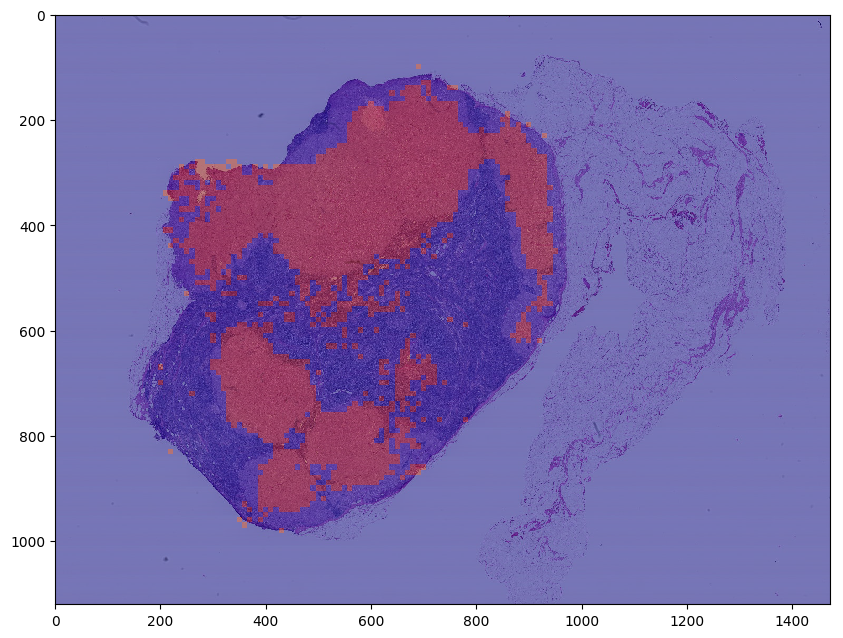

In [51]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

show_me_this_image(test_image_filename, level = level)
plt.imshow(predicted_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.